In [183]:
using Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/environmental-systems-analysis/website/slides`


In [184]:
using DataFrames
using LaTeXStrings
using PrettyTables
using JuMP
using HiGHS
using Plots
using Measures

## Overview of Economic Dispatch

A key goal in power systems operations is how to meet demand by generating electricity from a variety of generators with varying costs and engineering constraints, including:
* ramping limits;
* minimum/maximum power outputs;
* network constraints (we will ignore these here). 

**Economic dispatch** refers to solving this problem with an objective of minimizing total costs of production. Economic dispatch is typically formulated as a linear programming problem, and we will use `JuMP` to formulate and solve it for a simple portfolio of generators over:
* a single period
* multiple periods with ramping constraints.

## Single-Period Economic Dispatch

Let's say that we have a fleet of the following generators.

In [185]:
#| label: spgen-data
#| fig-align: center

header = ["Plant", "P<sub>min</sub> (MW)", "P<sub>max</sub> (MW)", "VarCost (\$/MW)"]
gen_names = ["Hydro", "Wind", "Nuclear", "Coal", "Natural Gas"]
gen_minpower = [0, 0, 200, 160, 40]
gen_maxpower = [150, 200, 1000, 700, 500]
gen_varcost = [0, 0, 2, 21.50, 23]
gen_data = DataFrame(name=gen_names, Pmin=gen_minpower, Pmax=gen_maxpower, varcost=gen_varcost)
pretty_table(gen_data; backend = Val(:html), header=header, allow_html_in_cells=true)

Plant,Pmin (MW),Pmax (MW),VarCost ($/MW)
Hydro,0,150,0.0
Wind,0,200,0.0
Nuclear,200,1000,2.0
Coal,160,700,21.5
Natural Gas,40,500,23.0


Let's also assume that demand in this period is 1800 MW.

## JuMP Formulation

In [186]:
demand = 1800

G = 1:nrow(gen_data)
dispatch = Model(HiGHS.Optimizer)
@variable(dispatch, gen_minpower[g] <= y[g in G] <= gen_maxpower[g])
@objective(dispatch, Min, sum(gen_varcost .* y))
@constraint(dispatch, load, sum(y) == demand)

latex_formulation(dispatch)

$$ \begin{aligned}
\min\quad & 2 y_{3} + 21.5 y_{4} + 23 y_{5}\\
\text{Subject to} \quad & y_{1} + y_{2} + y_{3} + y_{4} + y_{5} = 1800.0\\
 & y_{1} \geq 0.0\\
 & y_{2} \geq 0.0\\
 & y_{3} \geq 200.0\\
 & y_{4} \geq 160.0\\
 & y_{5} \geq 40.0\\
 & y_{1} \leq 150.0\\
 & y_{2} \leq 200.0\\
 & y_{3} \leq 1000.0\\
 & y_{4} \leq 700.0\\
 & y_{5} \leq 500.0\\
\end{aligned} $$

In [187]:
set_silent(dispatch)
optimize!(dispatch)

In [188]:
#| label: spdispatch-results
#| fig-align: center

gen_sol = value.(y).data
results = DataFrame(name=gen_names, dispatch=gen_sol
, pmin=gen_minpower, pmax=gen_maxpower)
results_header = ["Plant", "Dispatch (MW)", "P<sub>min</sub> (MW)", "P<sub>max</sub> (MW)"]
pretty_table(results; backend = Val(:html), header=results_header, allow_html_in_cells=true)


Plant,Dispatch (MW),Pmin (MW),Pmax (MW)
Hydro,150.0,0,150
Wind,200.0,0,200
Nuclear,1000.0,200,1000
Coal,410.0,160,700
Natural Gas,40.0,40,500


### Marginal Generators

Once we hit the minimum for each generator, we then "fill up" capacity from lowest-cost generators first, then move on.

For this problem, the coal generator is the **marginal generator**. If we had used all of our coal capacity, the natural gas unit would be the marginal generator. The concept of the marginal generator is important, as the marginal generation unit sets the price of electricity. 


### Merit Order and the Dispatch Stack

This procedure of starting with the lowest-cost generation and adding generation sequentially from generators in order of cost is the concept of **merit order**: plants are scheduled to supply additional electricity based (*mostly*) on their variable costs. We can visualize the **supply curve** (or the *dispatch stack*) to see the order in which electricity is dispatched.


In [189]:
supply_curve = DataFrame( 
    name = gen_names, 
    pmin = gen_minpower, 
    cap = gen_maxpower .- gen_minpower,
    varcost = gen_varcost 
)

sort!(supply_curve, [:varcost, order(:cap, rev=true)])

Row,name,pmin,cap,varcost
,String,Int64,Int64,Float64
1,Wind,0,200,0.0
2,Hydro,0,150,0.0
3,Nuclear,200,800,2.0
4,Coal,160,540,21.5
5,Natural Gas,40,460,23.0


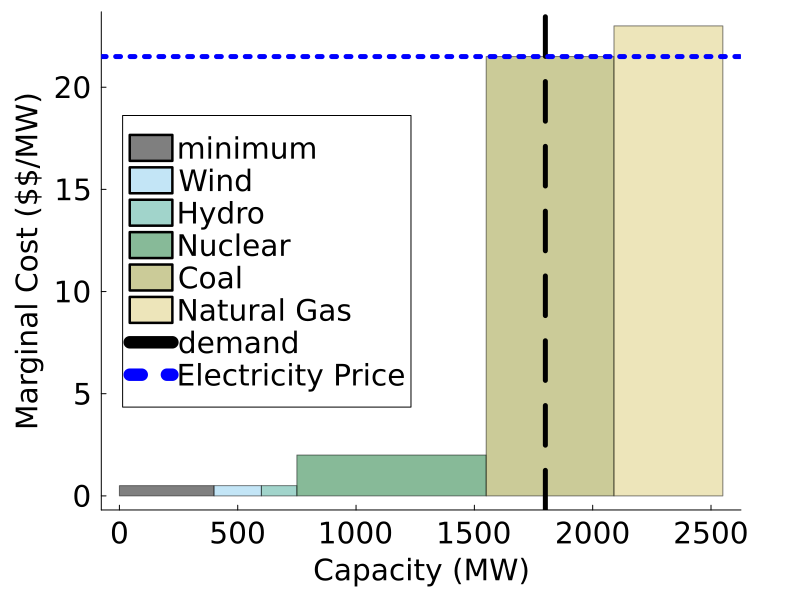

In [190]:
#| label: dispatch-stack
#| fig-align: center

rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h]) 

p = plot(grid=:false, color_palette=:tol_muted, legend=:left, legendfontsize=20, tickfontsize=20, guidefontsize=20) 
marg_gen = 0 
marg_price = 0 
x = 0 

plot!(p, rectangle(sum(supply_curve.pmin), 0.5, x, 0), opacity=.5, label = "minimum", color="black") 
x = x + sum(supply_curve.pmin) 
for i in 1:nrow(supply_curve) 
    if supply_curve[i, :varcost] == 0 
        plot!(p, rectangle(supply_curve[i, :cap], 0.5,x,0), opacity=.5, label = supply_curve[i, :name]) 
    else 
        plot!(p, rectangle(supply_curve[i, :cap], supply_curve[i, :varcost],x,0), opacity=.5, label = supply_curve[i, :name]) 
    end 
    if (x < demand) && (x + supply_curve[i,:cap] > demand) 
        marg_gen = i 
        marg_price = supply_curve[i,:varcost] 
    end 
    x = x + supply_curve[i,:cap] 
end 
vline!([demand],linecolor="black",linewidth=5, linestyle=:dash, label = "demand") 
hline!([marg_price],linecolor="blue", linestyle=:dot, linewidth=5, label = "Electricity Price") 
xlabel!("Capacity (MW)") 
ylabel!("Marginal Cost (\$/MW)") 
plot!(size=(800, 600))
plot!(right_margin=13mm, left_margin=5mm, bottom_margin=5mm)

## Multiple-Period Dispatch

What changes for multiple periods?

- Need to meet demand at every time period
- We have additional **ramping** constraints: plants can only increase and decrease their output by so much from time to time, by $R_g$.



### JuMP Implementation

In [191]:
ramp = [150, 200, 100, 250, 300]
demand = [1725, 1596, 1476, 1408, 1530, 1714, 1820, 1973, 2081, 2202, 2105, 2065, 
    2045, 2195, 2309, 2390, 2486, 2515, 2075, 2006, 1956, 1902, 1865, 1820]
h = length(demand)
T = 1:h

dispatch2 = Model(HiGHS.Optimizer)
@variable(dispatch2, gen_minpower[g] <= y[g in G, t in T] <= gen_maxpower[g])
@objective(dispatch2, Min, sum(gen_varcost .* sum([y[:, t] for t in T])))
@constraint(dispatch2, load[t in T], sum(y[:, t]) == demand[t])
@constraint(dispatch2, rampup[g in G, t in 1:h-1], y[g, t+1] - y[g, t] <= ramp[g])
@constraint(dispatch2, rampdown[g in G, t in 1:h-1], y[g, t] - y[g, t+1] <= ramp[g])

latex_formulation(dispatch2)

$$ \begin{aligned}
\min\quad & 2 y_{3,1} + 2 y_{3,2} + 2 y_{3,3} + 2 y_{3,4} + 2 y_{3,5} + 2 y_{3,6} + 2 y_{3,7} + 2 y_{3,8} + 2 y_{3,9} + 2 y_{3,10} + 2 y_{3,11} + 2 y_{3,12} + 2 y_{3,13} + 2 y_{3,14} + 2 y_{3,15} + 2 y_{3,16} + 2 y_{3,17} + 2 y_{3,18} + 2 y_{3,19} + 2 y_{3,20} + 2 y_{3,21} + 2 y_{3,22} + 2 y_{3,23} + 2 y_{3,24} + 21.5 y_{4,1} + 21.5 y_{4,2} + 21.5 y_{4,3} + 21.5 y_{4,4} + 21.5 y_{4,5} + 21.5 y_{4,6} + 21.5 y_{4,7} + 21.5 y_{4,8} + 21.5 y_{4,9} + 21.5 y_{4,10} + 21.5 y_{4,11} + 21.5 y_{4,12} + 21.5 y_{4,13} + 21.5 y_{4,14} + 21.5 y_{4,15} + 21.5 y_{4,16} + 21.5 y_{4,17} + 21.5 y_{4,18} + 21.5 y_{4,19} + 21.5 y_{4,20} + 21.5 y_{4,21} + 21.5 y_{4,22} + 21.5 y_{4,23} + 21.5 y_{4,24} + 23 y_{5,1} + 23 y_{5,2} + 23 y_{5,3} + 23 y_{5,4} + 23 y_{5,5} + 23 y_{5,6} + 23 y_{5,7} + 23 y_{5,8} + 23 y_{5,9} + 23 y_{5,10} + 23 y_{5,11} + 23 y_{5,12} + 23 y_{5,13} + 23 y_{5,14} + 23 y_{5,15} + 23 y_{5,16} + 23 y_{5,17} + 23 y_{5,18} + 23 y_{5,19} + 23 y_{5,20} + 23 y_{5,21} + 23 y_{

In [192]:

set_silent(dispatch2)
optimize!(dispatch2)

gen = value.(y).data


5×24 Matrix{Float64}:
  150.0   150.0  150.0  128.0  150.0  …   150.0   150.0   150.0   150.0
  200.0   200.0  200.0  200.0  200.0      200.0   200.0   200.0   200.0
 1000.0  1000.0  926.0  880.0  980.0     1000.0  1000.0  1000.0  1000.0
  335.0   206.0  160.0  160.0  160.0      566.0   512.0   475.0   430.0
   40.0    40.0   40.0   40.0   40.0       40.0    40.0    40.0    40.0

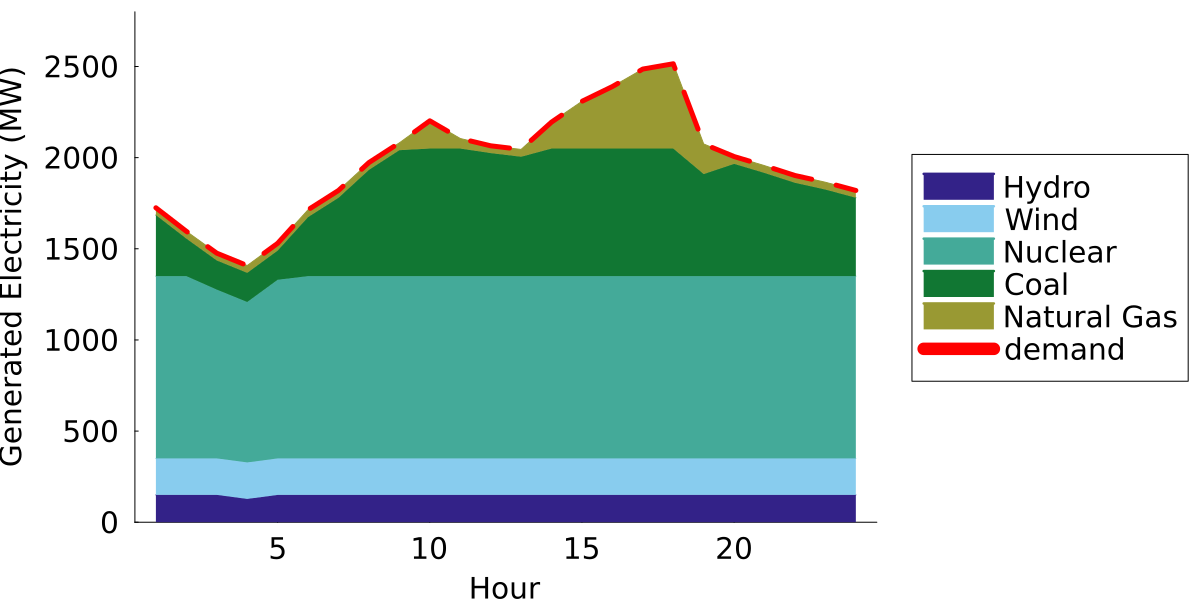

In [193]:
#| label: mpdispatch-stacked
#| fig-align: center

areaplot(gen', 
    label=permutedims(gen_names), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:tol_muted, 
    size=(1200, 600), 
    left_margin=6mm, 
    bottom_margin=6mm,
    grid=:false,
    legend = :outerright, ylim=(0, 2800),
    legendfontsize=20, tickfontsize=20, 
    guidefontsize=20
)
plot!(demand, color=:red, 
    label="demand", linestyle=:dash,
    linewidth=5)

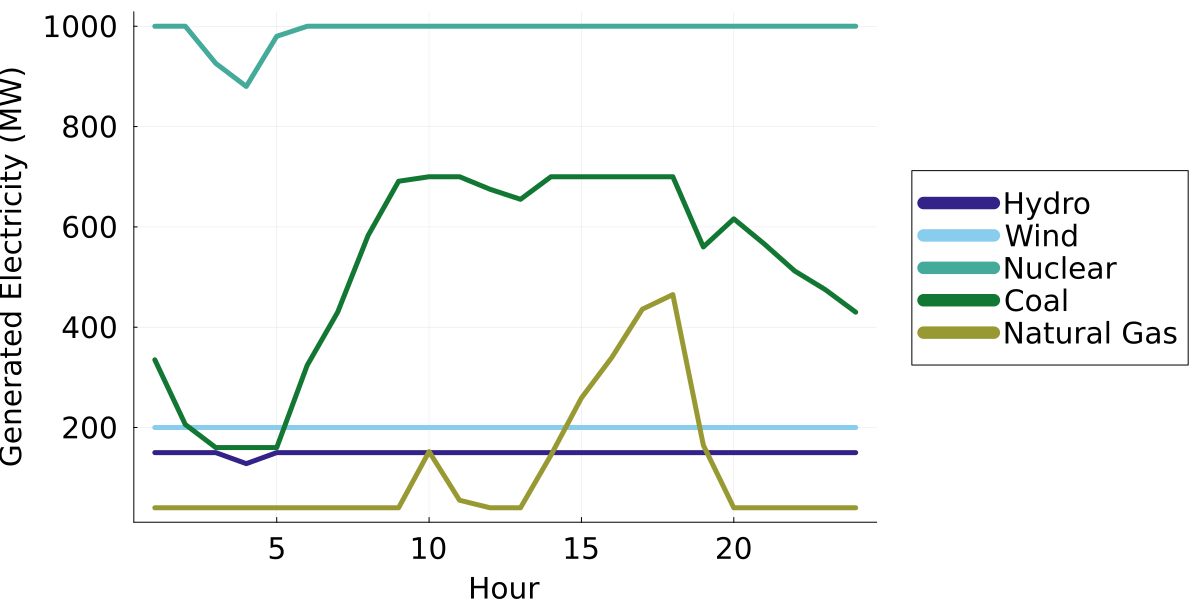

In [194]:
#| label: mpdispatch-results
#| fig-align: center

p = plot(gen', 
    label=permutedims(gen_names), 
    xlabel = "Hour", 
    ylabel ="Generated Electricity (MW)", 
    color_palette=:tol_muted, 
    linewidth=5,
    size=(1200, 600), left_margin=6mm, 
    bottom_margin=6mm,
    legendfontsize=20, tickfontsize=20, 
    guidefontsize=20,
    legend=:outerright
)

Notice that even though hydro is effectively zero-cost, we reduce dispatched hydropower in hour 4 because coal is at its minimum generating capacity and nuclear can't be ramped down further. These constraints complicate the simple merit order that we previously saw.

These constraints also play a major role in systems with high levels of renewable penetration. For example, the so-called California "duck curve" is created by the challenges of ramping generation between the early afternoon, when solar generation is at its maximum, and in the evening, when solar generation is decreasing and demand increases rapidly.

![California Duck Curve](../figures/duck_curve.jpeg)